In [1]:
using Revise
using TaD
using DifferentialEquations, Flux, DiffEqFlux
using Plots
import IJulia

# BSpline trajectory

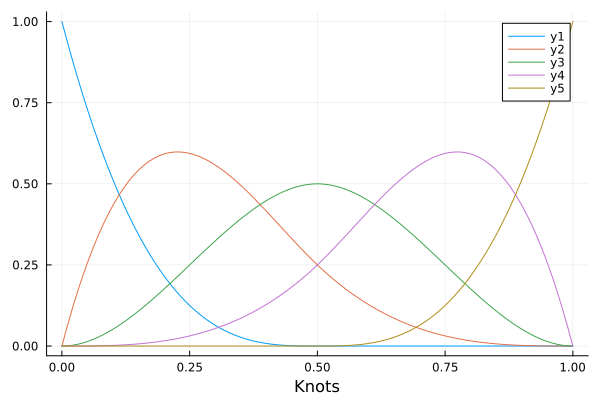

In [2]:
kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
basis = BSplineBasis(kv, 3, k=3)
plot(basis, k=0)

In [3]:
control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
c = BSplineCurve(basis, control_points)
c(1.0)

4×3 Matrix{Float64}:
  1.0   1.0   1.0
  4.5   4.5   0.6
 15.0  15.0   3.6
 25.8  25.8  11.4

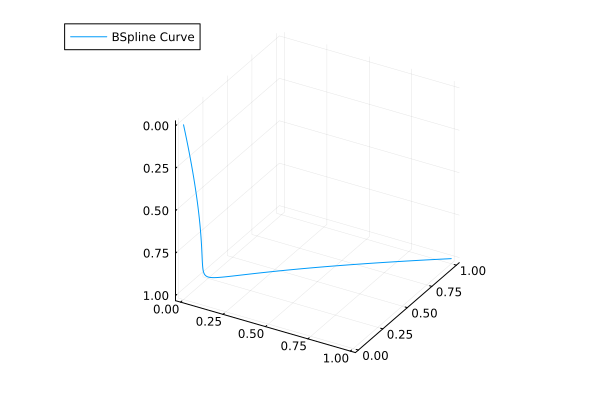

In [4]:
plot(c, zflip=true)

# Forward solution

For demonstration purposes, we'll be solving the soft string equation:

$$\frac{dF_t}{ds} = -w_{bp} \hat{t}_3 + \mu w_c,$$

where

$$w_{bp} = A g (\rho_p - \rho_m),$$

and

$$w_c = \sqrt{\left(F_t \kappa + w_{bp} \hat{n}_3\right)^2 + \left(w_{bp} \hat{b}_3 \right)^2}.$$

$\hat{t}, \hat{n}, \hat{b}$ are the tangential, normal, and bi-normal vectors in the Frenet frame that follows the drillstring trajectory.  From the position vector along trajectory curve defined by the B-Splines $\vec{r} = \vec{r}(s)$ these are defined as

$$\hat{t} = \frac{\vec{r}^\prime}{\left\Vert \vec{r}^\prime \right\Vert},$$

$$\hat{b} = \frac{\vec{r}^{\prime\prime}}{\left\Vert \vec{r}^{\prime\prime} \right\Vert},$$

$$\hat{n} = \hat{t} \times \hat{b},$$

and finally, $\kappa$ is the curvature defined by

$$\kappa = \frac{\left\Vert \vec{r}^{\prime} \times \vec{r}^{\prime\prime} \right\Vert}{\left\Vert \vec{r}^\prime \right\Vert^3}$$.

$\mu$ is the friction factor, $\rho_p$ and $\rho_m$ are the densities of the drill pipe and drilling mud respectively, $A$ is the cross-sectional area of the pipe, and $g$ is acceration due to gravity. We will be determining the axial force on the drill string throughout the wellpath, with an unknown coefficient of friction.

In [5]:
function parameterized_soft_string_drag1!(dF,F,p,s)
    kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
    basis = BSplineBasis(kv, 3, k=3)
    control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
    c = BSplineCurve(basis, control_points)
    
    p_ = [p[1], 0.1683, 0.09525, 9.81, 7800, 1298, c]
    soft_string_drag!(dF, F, p_, s)
end

parameterized_soft_string_drag1! (generic function with 1 method)

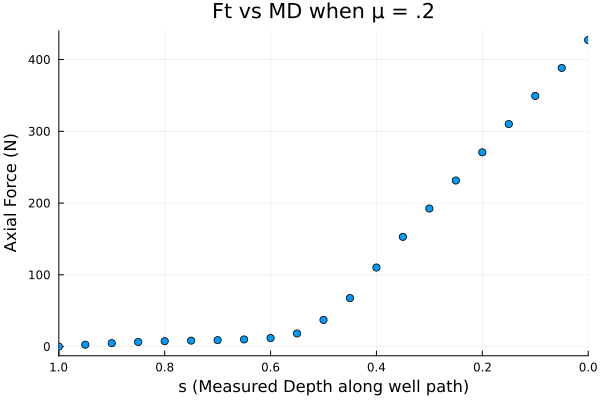

In [6]:
u0 = [0.0]
tspan = (1.0,0.0)
prob1 = ODEProblem(parameterized_soft_string_drag1!, u0, tspan, 0.2, saveat=0.05) #u0 is initial value, tspan is domain, .2 is coeff friction μ
sol1 = solve(prob1)
scatter(sol1, xlabel="s (Measured Depth along well path)", ylabel="Axial Force (N)", legend=false, title="Ft vs MD when μ = .2")

In [7]:
μ = [0.0]
params = Flux.params(μ)

function predict_tad1() # Our 1-layer "neural network"
  solve(prob1,p=μ,saveat=0.05)[1,:] # override with new parameters
end

loss1() = sum(abs2,x-sol1[1,i] for (i,x) in enumerate(predict_tad1())) # loss function

loss1 (generic function with 1 method)

# Parameter estimation

The goal here is to solve the following minimization problem

$$\frac{\partial}{\partial \mu}\left(y_{data} - \int_{s_b}^0 \frac{dF_t(\mu, s)}{ds} ds\right)^2 = 0$$

Without having knowledge of the value of the constant coefficient of coulomb friction, in this case 0.2

"Loss: 24.989502712390333"

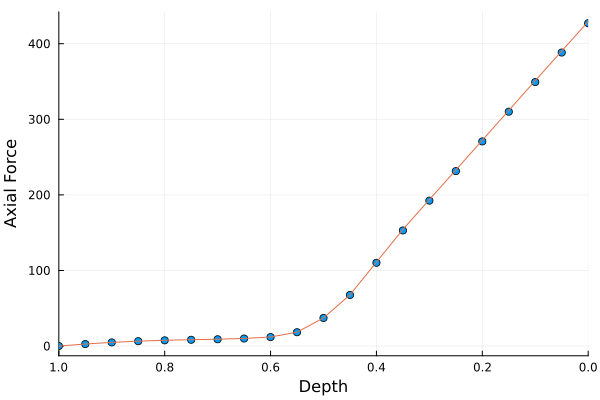

LoadError: Stopping training!

In [8]:
dat = Iterators.repeated((), 100)

cb = function () #callback function to observe training
  sleep(0.1)
  IJulia.clear_output(true)
  IJulia.display("Loss: $(loss1())")
  # using `remake` to re-create our `prob` with current parameters `p`
  scatter(sol1, xlabel = "Depth", ylabel = "Axial Force", legend=false)
  IJulia.display(plot!(solve(remake(prob1,p=μ),saveat=0.05), xlabel="Depth", legend=false))
  if loss1() < 40.0
    throw(ErrorException("Stopping training!"))
    #flux.stop() is deprecated i think
  end
end

# Display the ODE with the initial parameter values.
cb()

for i in 1:6
    @info "Epoch $i"
    Flux.train!(loss1, params, dat, ADAM(), cb = cb)
end

# SciML

Now, let's consider a spatially varying friction factor of the form

$$\mu(s) = 0.9 s^3 + 0.001$$

We will use DiffEQFlux.jl's NeuralODE to define an ODE with a simple continuous-time recurrant neural network (provided by Lux.jl) set as the gradient. We will then use Optimization.jl and Optim.jl to fit this NueralODE to approximate the true solution to the above defined ODE (with a variable coefficient of friction) for the Axial force along the wellpath, $F_{t}$. 

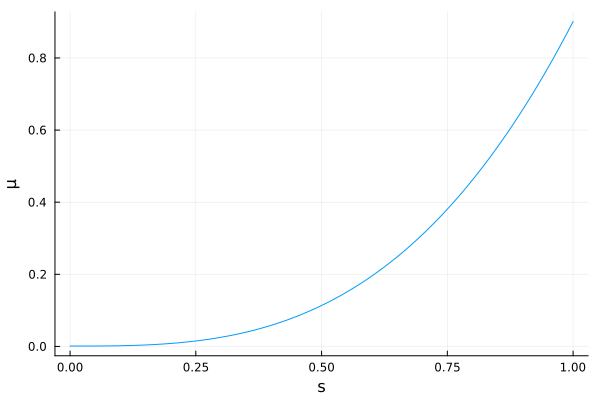

In [9]:
μf(x) = 0.9 * x ^ 3 + 0.001
plot(0:0.01:1, μf, xlabel="s", ylabel="μ",legend=false)

In [10]:
function parameterized_soft_string_drag2!(dF,F,p,s)
    kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
    basis = BSplineBasis(kv, 3, k=3)
    control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
    c = BSplineCurve(basis, control_points)
    p_ = [μf(s), 0.1683, 0.09525, 9.81, 7800, 1298, c]
    soft_string_drag!(dF, F, p_, s)
end

parameterized_soft_string_drag2! (generic function with 1 method)

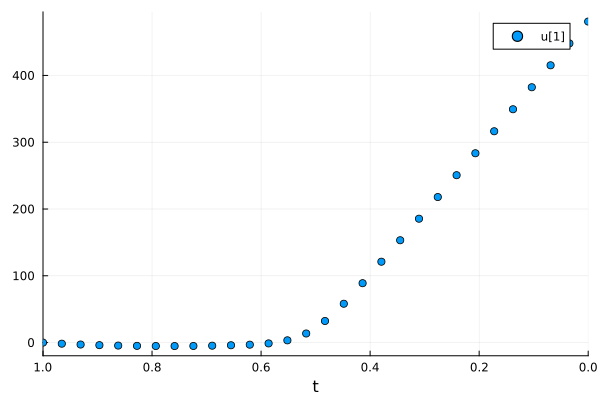

In [11]:
μ0 = [0.0]
datasize = 30
tspan = (1.0, 0.0)
tsteps = range(tspan[1], tspan[2]; length = datasize)
prob2 = ODEProblem(parameterized_soft_string_drag2!, u0, tspan, saveat=tsteps)
sol2 = solve(prob2)
ode_data = Array(sol2)
scatter(sol2)

The goal now is to solve the following minimization problem

$$\frac{\partial}{\partial \theta}\left(y_{data} - \int_{s_b}^0 \frac{dF_t\left(\mathcal{NN}_{\theta}(s)\right)}{ds} ds\right)^2 = 0$$

where $F_t$ is

$$\frac{dF_t}{ds} = -w_{bp} \hat{t}_3 + \mathcal{NN}_{\theta}(s) w_c,$$

In [12]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL, OptimizationOptimisers, Random, Plots, TaD

rng = Random.default_rng()
dudt2 = Lux.Chain(Lux.Dense(1, 50, tanh), Lux.Dense(50, 1)) #The second dimension must be equal to length μ0. First is bc odedata has length 50

p, st = Lux.setup(rng, dudt2)
tad_3 = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps);

In [13]:
function predict_tad3(p)
    #Array(prob_neuralode(u0, p, st)[1])
    Array(tad_3(μ0, p, st)[1])
end

function loss3(p)
    pred = predict_tad3(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

loss3 (generic function with 1 method)

Iteration 1 has loss 1.2483127334149755e6


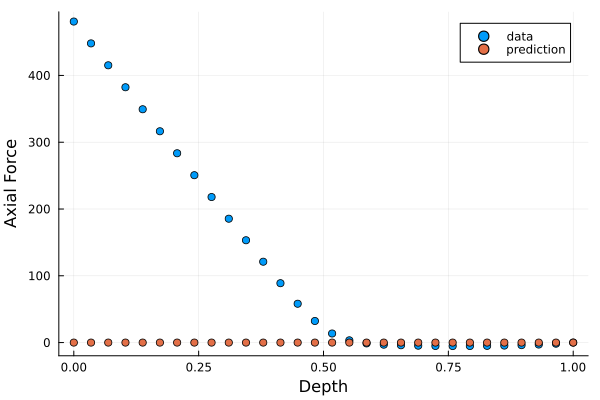

Iteration 5 has loss 1.245451954128852e6
Iteration 10 has loss 1.235735684922812e6
Iteration 15 has loss 1.216755017580547e6
Iteration 20 has loss 1.1918680032129558e6
Iteration 25 has loss 1.1649265371951042e6
Iteration 30 has loss 1.1383332612941922e6
Iteration 35 has loss 1.1147320414835685e6
Iteration 40 has loss 1.0935620988844724e6
Iteration 45 has loss 1.0738415592769966e6
Iteration 50 has loss 1.055162972890257e6
Iteration 55 has loss 1.0373176304064231e6
Iteration 60 has loss 1.020174992952758e6
Iteration 65 has loss 1.0036418138371011e6
Iteration 70 has loss 987646.5424984959
Iteration 75 has loss 972132.4209279628
Iteration 80 has loss 957053.3869078741
Iteration 85 has loss 942371.8270081296
Iteration 90 has loss 928056.6927733219
Iteration 95 has loss 914082.055344345
Iteration 100 has loss 900426.1875130157
Iteration 105 has loss 887070.6710080238
Iteration 110 has loss 873999.7225412815
Iteration 115 has loss 861196.2335891697
Iteration 120 has loss 848658.8724957971
Ite

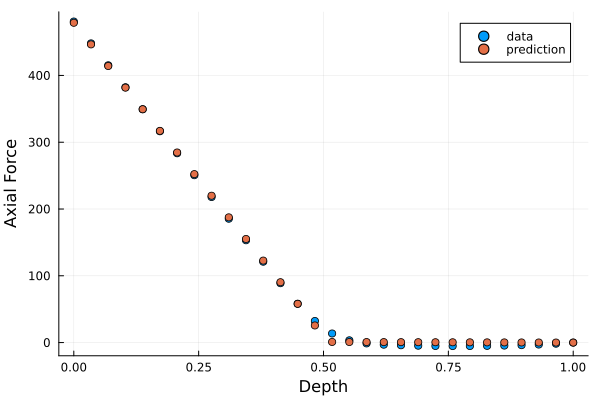

Iteration 1025 has loss 479.02970745602204
Iteration 1027 has loss 479.02970745602204


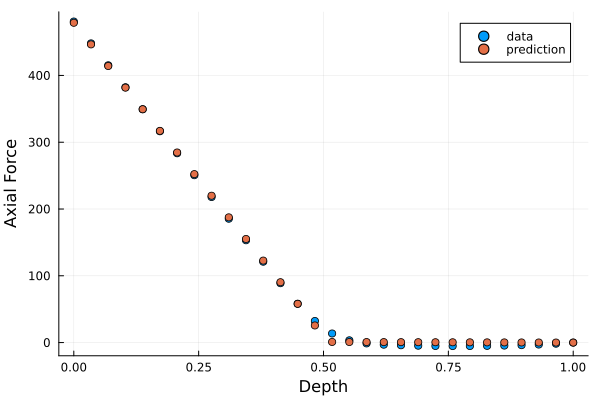

false

In [24]:
#Most of the time for me it gets to error of abt ~500
cnt = [0]
callback = function (p, l, pred; doplot = false)
    cnt[1] = cnt[1]+1
    if cnt[1] % 5 == 0 || doplot
        println("Iteration $(cnt[1]) has loss $(l)")
    end
    if doplot
        plt = scatter(tsteps, ode_data[1, :]; label = "data", xlabel="Depth", ylabel="Axial Force")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction", xlabel="Depth", ylabel="Axial Force")
        IJulia.display(plot(plt))
    end
    #if l < 500.0
     #   println("Iteration $(cnt[1]) has loss $(l)")
      #  plt = scatter(tsteps, ode_data[1, :]; label = "data", xlabel="Depth", ylabel="Axial Force")
       # scatter!(plt, tsteps, pred[1, :]; label = "prediction", xlabel="Depth", ylabel="Axial Force")
        #IJulia.display(plot(plt))
        #throw(ErrorException("Stopping training!"))
        #flux.stop() is deprecated i think
    #end
    return false
end

pinit = ComponentArray(p)
callback(pinit, loss3(pinit)...; doplot = true)

# use Optimization.jl to solve the problem
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> loss3(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

#result_neuralode = Optimization.solve(optprob, OptimizationOptimJL.BFGS(; initial_stepnorm = .001); callback = callback, maxiters=10000)
#result_neuralode = Optimization.solve(optprob, Optim.ConjugateGradient(); callback = callback, maxiters=10000)
#result_neuralode = Optimization.solve(optprob, Optim.NelderMead(); callback = callback)
result_neuralode = Optimization.solve(optprob, OptimizationOptimisers.Adam(.01); callback = callback, maxiters=1000)
result_neuralode = Optimization.solve(optprob, OptimizationOptimJL.BFGS(; initial_stepnorm = .001); callback = callback, maxiters=10000)

callback(result_neuralode.u, loss3(result_neuralode.u)...; doplot = true)
optprob = Optimization.OptimizationProblem(optf, result_neuralode.u)
res2 = Optimization.solve(optprob, BFGS(initial_stepnorm=0.01, linesearch = LineSearches.BackTracking()), callback = callback, maxiters = 1000)
callback(res2.u, loss3(res2.u)...; doplot = true)

Iteration [1] has loss 99360.9903319907


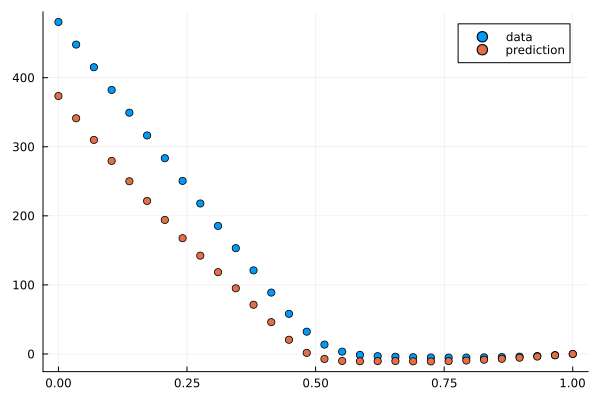

Iteration [2] has loss 99360.9903319907
Iteration [3] has loss 85258.6077525033
Iteration [4] has loss 72842.19910830026
Iteration [5] has loss 62032.855964119924
Iteration [6] has loss 52599.00797271169
Iteration [7] has loss 44484.64293175062
Iteration [8] has loss 37412.50186460427
Iteration [9] has loss 31355.86247086996
Iteration [10] has loss 26712.666467573777
Iteration [11] has loss 23081.388361545585
Iteration [12] has loss 20085.472528552407
Iteration [13] has loss 17552.081024008425
Iteration [14] has loss 15377.48466896597
Iteration [15] has loss 13482.54610048102
Iteration [16] has loss 11865.332187126682
Iteration [17] has loss 10426.58503066716
Iteration [18] has loss 9162.58303043729
Iteration [19] has loss 8086.776062556925
Iteration [20] has loss 7107.091230915965
Iteration [21] has loss 6261.796535020367
Iteration [22] has loss 5506.915934208684
Iteration [23] has loss 4841.300196869759
Iteration [24] has loss 4257.922090623802
Iteration [25] has loss 3748.2986860665

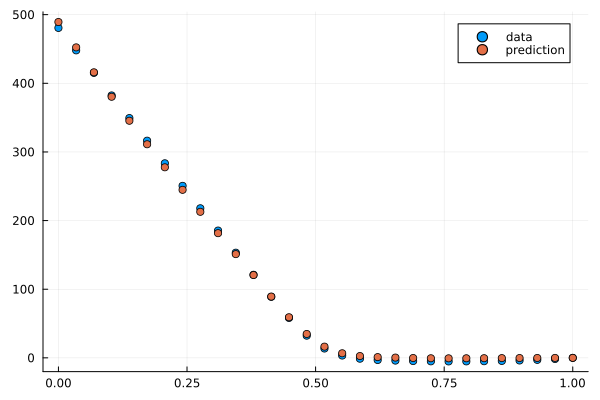

false

In [25]:
dudt2 = Lux.Chain(Lux.Dense(1, 20, tanh), Lux.Dense(20, 1)) #The second dimension must be equal to length μ0
ps, st = Lux.setup(rng, dudt2)
NN_params = ComponentArray{Float64}(ps)

function parameterized_soft_string_drag3!(dF,F,p,s)
    kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
    basis = BSplineBasis(kv, 3, k=3)
    control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
    c = BSplineCurve(basis, control_points)
    nn_output = ComponentArray(dudt2([s[1]], p, st)[1])
    p_ = [nn_output[1], 0.1683, 0.09525, 9.81, 7800, 1298, c]
    TaD.soft_string_drag!(dF, F, p_, s)
end

function ODE_model(du, u, NN_params, t)
    parameterized_soft_string_drag3!(du, u, NN_params, t)
    return du
end

NN_params = NN_params .* 0 + Float64(1e-4)*randn(eltype(NN_params), size(NN_params))
prob_neuralode = ODEProblem(ODE_model, μ0, tspan, NN_params, saveat = tsteps)

function predict_neuralode(θ)
    soln = solve(prob_neuralode, RK4(); u0 = μ0,p=θ, saveat=tsteps)
    Array(soln)
end


function loss_neuralode(NN_params)
    pred = predict_neuralode(NN_params)
    loss = sum(abs2, ode_data .- Array(pred))
    return loss, pred
end

cnt = [0]
losses = []
callback = function (p, l, pred; doplot = false)
    cnt[1] = cnt[1]+1
    println("Iteration $(cnt) has loss $(l)")
    push!(losses, l)
    # plot current prediction against data
    if doplot
        plt = scatter(tsteps, ode_data[1, :]; label = "data")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction")
        display(plot(plt))
    end
    return false
end


NN_params = NN_params .* 0 + Float64(1e-4)*randn(eltype(NN_params), size(NN_params))

pinit = ComponentArray(ps)
callback(pinit, loss_neuralode(pinit)...; doplot = true)

adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentArray(ps))
result_neuralode = Optimization.solve(optprob, OptimizationOptimisers.Adam(); callback = callback, maxiters = 1000)
#
optprob = Optimization.OptimizationProblem(optf, result_neuralode.u)
res2 = Optimization.solve(optprob, BFGS(initial_stepnorm=0.01, linesearch = LineSearches.BackTracking()), callback = callback, maxiters = 1000)
callback(res2.u, loss_neuralode(res2.u)...; doplot = true)

# Things to do

 * Trajectory reconstruction from survey data
 * Validate models
 * Train SciML models w/ real data